In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
data = pd.read_csv('AAPL.csv')
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
1,2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2,2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
3,2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
4,2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600
5,2016-11-21,27.530001,27.997499,27.502501,27.932501,26.239609,117058400
6,2016-11-22,27.987499,28.105000,27.850000,27.950001,26.256044,103862000
7,2016-11-23,27.840000,27.877501,27.582500,27.807501,26.122183,109705600
8,2016-11-25,27.782499,27.967501,27.737499,27.947500,26.253696,45903600
9,2016-11-28,27.857500,28.117500,27.847500,27.892500,26.202034,108776000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1008 non-null   object 
 1   Open       1008 non-null   float64
 2   High       1008 non-null   float64
 3   Low        1008 non-null   float64
 4   Close      1008 non-null   float64
 5   Adj Close  1008 non-null   float64
 6   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.2+ KB


In [4]:
series = data[['Open']]
time = np.array(range(len(series)))

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

In [6]:
series.shape

(1008, 1)

In [7]:
series = series.reshape(-1)

In [8]:
series.shape

(1008,)

In [9]:
series

array([2.56878262e-03, 0.00000000e+00, 2.92922339e-04, ...,
       8.16129298e-01, 8.38031559e-01, 8.36409161e-01])

In [10]:
split_time = int(len(series) * 0.8)

time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time: ]
x_valid = series[split_time: ]

In [11]:
def plot_series(time, series, start=0, end = None, sign = '-'):
    plt.plot(time[start:end], series[start:end], sign)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

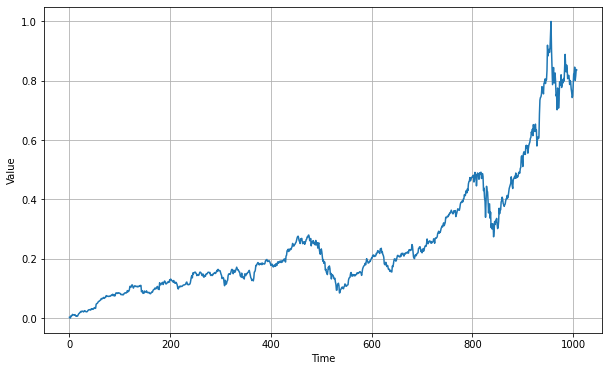

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

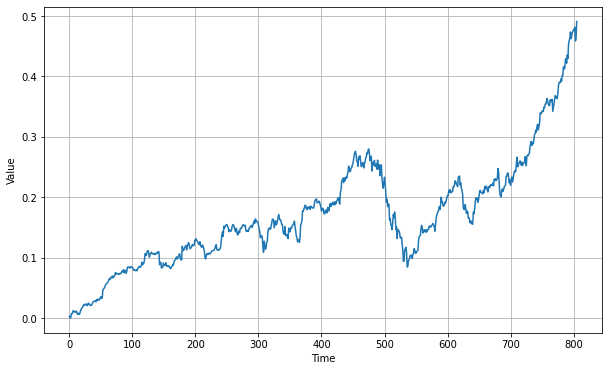

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)

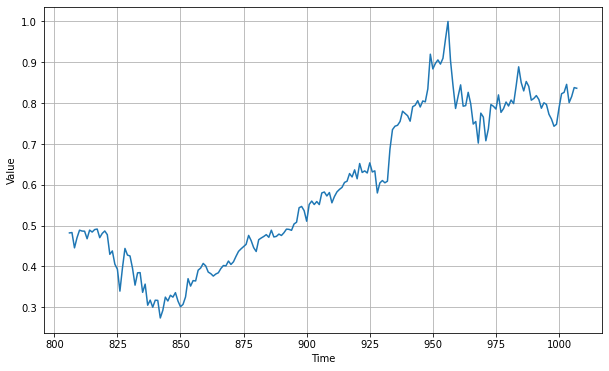

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [15]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[: -1], window[-1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
batch_size = 32
shuffle_buffer = 100

training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss = 'mse',
              optimizer = 'adam')

history = model.fit(training, epochs = 100)

Epoch 1/100
25/25 [==============================] - 6s 44ms/step - loss: 0.4436
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0825
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0176
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0189
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0330
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0149
Epoch 7/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0055
Epoch 8/100
25/25 [==============================] - 1s 21ms/step - loss: 3.5842e-04
Epoch 9/100
25/25 [==============================] - 1s 22ms/step - loss: 4.1991e-04
Epoch 10/100
25/25 [==============================] - 1s 23ms/step - loss: 2.1966e-04
Epoch 11/100
25/25 [==============================] - 1s 23ms/step - loss: 1.8123e-04
Epoch 12/100
25/25 [==============================] - 1s 22ms/step - loss: 2.3380e-04
Epoch

25/25 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 98/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 99/100
25/25 [==============================] - 1s 20ms/step - loss: 6.1759e-04
Epoch 100/100
25/25 [==============================] - 1s 20ms/step - loss: 7.5105e-04


In [18]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size: ]

In [19]:
results = np.array(forecast)[:, 0, 0]

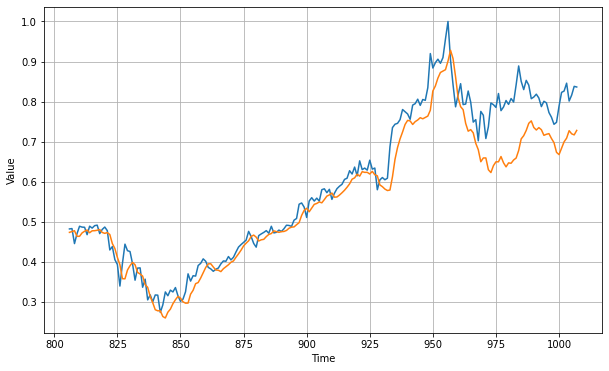

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
results[:10]

array([0.4735877 , 0.47548813, 0.477654  , 0.46364757, 0.4637436 ,
       0.47214702, 0.476347  , 0.47945157, 0.47262487, 0.47746953],
      dtype=float32)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.044069517

In [23]:
series = data['Open'].values
time = np.array(range(len(series)))
split_time = int(len(series) * 0.8)

time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time: ]
x_valid = series[split_time: ]

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
batch_size = 32
shuffle_buffer = 100

training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss = 'mse',
              optimizer = 'adam')

history = model.fit(training, epochs = 100)

Epoch 1/100
25/25 [==============================] - 5s 22ms/step - loss: 140.0068
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 203.1992
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 120.6517
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 55.3824
Epoch 5/100
25/25 [==============================] - 1s 26ms/step - loss: 25.6594
Epoch 6/100
25/25 [==============================] - 1s 24ms/step - loss: 14.7467
Epoch 7/100
25/25 [==============================] - 1s 26ms/step - loss: 7.9447
Epoch 8/100
25/25 [==============================] - 1s 26ms/step - loss: 7.6875
Epoch 9/100
25/25 [==============================] - 1s 26ms/step - loss: 6.3659
Epoch 10/100
25/25 [==============================] - 1s 20ms/step - loss: 4.9884
Epoch 11/100
25/25 [==============================] - 1s 21ms/step - loss: 3.9497
Epoch 12/100
25/25 [==============================] - 1s 22ms/step - loss: 3.5816
Epoch 13/100
25/

25/25 [==============================] - 0s 18ms/step - loss: 0.7958


In [26]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size: ]
results = np.array(forecast)[:, 0, 0]

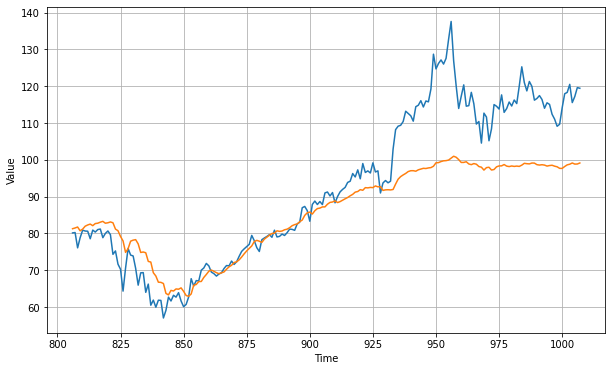

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.577151

# Option2

In [35]:
series = data[['Open']]
time = np.array(range(len(series)))

In [36]:
scaler = MinMaxScaler()
series = scaler.fit_transform(series)

In [37]:
series = series.reshape(-1)

In [38]:
split_time = int(len(series) * 0.8)

time_train = time[: split_time]
x_train = series[: split_time]

time_valid = time[split_time: ]
x_valid = series[split_time: ]

In [41]:
window_size = 30
batch_size = 32
shuffle_buffer = 1000

training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/20))

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.09))

history = model.fit(training, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
25/25 [==============================] - 5s 20ms/step - loss: 1.5702 - lr: 1.0000e-06
Epoch 2/100
25/25 [==============================] - 1s 19ms/step - loss: 0.8761 - lr: 1.1220e-06
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 0.6075 - lr: 1.2589e-06
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 0.5405 - lr: 1.4125e-06
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 0.5269 - lr: 1.5849e-06
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 0.5206 - lr: 1.7783e-06
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 0.5153 - lr: 1.9953e-06
Epoch 8/100
25/25 [==============================] - 1s 20ms/step - loss: 0.5091 - lr: 2.2387e-06
Epoch 9/100
25/25 [==============================] - 1s 19ms/step - loss: 0.5021 - lr: 2.5119e-06
Epoch 10/100
25/25 [==============================] - 1s 18ms/step - loss: 0.4944 - lr: 2.8184e-06
Epoch 11/100
25/25 

25/25 [==============================] - 1s 25ms/step - loss: 72.2984 - lr: 0.0141
Epoch 85/100
25/25 [==============================] - 1s 20ms/step - loss: 79.2804 - lr: 0.0158
Epoch 86/100
25/25 [==============================] - 1s 20ms/step - loss: 88.0964 - lr: 0.0178
Epoch 87/100
25/25 [==============================] - 0s 17ms/step - loss: 98.8965 - lr: 0.0200
Epoch 88/100
25/25 [==============================] - 1s 18ms/step - loss: 113.2176 - lr: 0.0224
Epoch 89/100
25/25 [==============================] - 1s 18ms/step - loss: 123.1205 - lr: 0.0251
Epoch 90/100
25/25 [==============================] - 0s 17ms/step - loss: 138.6439 - lr: 0.0282
Epoch 91/100
25/25 [==============================] - 0s 17ms/step - loss: 153.5262 - lr: 0.0316
Epoch 92/100
25/25 [==============================] - 0s 18ms/step - loss: 172.6905 - lr: 0.0355
Epoch 93/100
25/25 [==============================] - 0s 17ms/step - loss: 189.0453 - lr: 0.0398
Epoch 94/100
25/25 [===========================

(0.01, 1.0, 0.0, 0.0001)

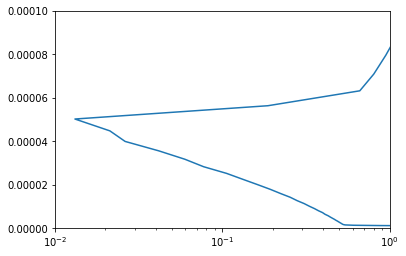

In [49]:
plt.semilogx(history.history['loss'], history.history['lr'])
plt.axis([1e-2, 1, 0, 0.0001])

In [51]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])


model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-2, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(training, epochs = 100)

Epoch 1/100
25/25 [==============================] - 5s 20ms/step - loss: 132.0359 - mae: 132.5355
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 52.6808 - mae: 53.1808
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 51.5400 - mae: 52.0400
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 52.6024 - mae: 53.1024
Epoch 5/100
25/25 [==============================] - 1s 19ms/step - loss: 52.4065 - mae: 52.9065
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 51.6172 - mae: 52.1172
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 51.5669 - mae: 52.0669
Epoch 8/100
25/25 [==============================] - 0s 16ms/step - loss: 52.4492 - mae: 52.9492
Epoch 9/100
25/25 [==============================] - 0s 17ms/step - loss: 52.3919 - mae: 52.8919
Epoch 10/100
25/25 [==============================] - 0s 17ms/step - loss: 51.6178 - mae: 52.1178
Epoch 11/100
25/25 [=======

25/25 [==============================] - 0s 18ms/step - loss: 52.4347 - mae: 52.9347
Epoch 85/100
25/25 [==============================] - 0s 18ms/step - loss: 52.3797 - mae: 52.8797
Epoch 86/100
25/25 [==============================] - 1s 19ms/step - loss: 51.6039 - mae: 52.1039
Epoch 87/100
25/25 [==============================] - 1s 18ms/step - loss: 51.5432 - mae: 52.0432
Epoch 88/100
25/25 [==============================] - 0s 18ms/step - loss: 52.4362 - mae: 52.9362
Epoch 89/100
25/25 [==============================] - 0s 18ms/step - loss: 52.3753 - mae: 52.8753
Epoch 90/100
25/25 [==============================] - 0s 18ms/step - loss: 51.5961 - mae: 52.0961
Epoch 91/100
25/25 [==============================] - 0s 18ms/step - loss: 51.5512 - mae: 52.0512
Epoch 92/100
25/25 [==============================] - 0s 18ms/step - loss: 52.4380 - mae: 52.9380
Epoch 93/100
25/25 [==============================] - 0s 18ms/step - loss: 52.3696 - mae: 52.8696
Epoch 94/100
25/25 [=============

In [52]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])


model.compile(loss = tf.keras.losses.Huber(),
              optimizer = 'adam',
              metrics = ['mae'])

history = model.fit(training, epochs = 100)

Epoch 1/100
25/25 [==============================] - 4s 19ms/step - loss: 0.3354 - mae: 0.6551
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0151 - mae: 0.1437
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0028 - mae: 0.0602
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 5.0489e-04 - mae: 0.0251
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 3.6312e-04 - mae: 0.0213
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 2.7630e-04 - mae: 0.0189
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 1.7919e-04 - mae: 0.0146
Epoch 8/100
25/25 [==============================] - 0s 16ms/step - loss: 2.4797e-04 - mae: 0.0178
Epoch 9/100
25/25 [==============================] - 0s 16ms/step - loss: 1.7188e-04 - mae: 0.0144
Epoch 10/100
25/25 [==============================] - 0s 16ms/step - loss: 2.1706e-04 - mae: 0.0165
Epoch 11/100
25/25 [=

25/25 [==============================] - 0s 17ms/step - loss: 3.4755e-04 - mae: 0.0221
Epoch 84/100
25/25 [==============================] - 0s 16ms/step - loss: 7.0007e-04 - mae: 0.0308
Epoch 85/100
25/25 [==============================] - 0s 16ms/step - loss: 3.4456e-04 - mae: 0.0204
Epoch 86/100
25/25 [==============================] - 0s 16ms/step - loss: 1.4461e-04 - mae: 0.0139
Epoch 87/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0398
Epoch 88/100
25/25 [==============================] - 0s 16ms/step - loss: 2.6704e-04 - mae: 0.0173
Epoch 89/100
25/25 [==============================] - 0s 17ms/step - loss: 1.5225e-04 - mae: 0.0144
Epoch 90/100
25/25 [==============================] - 0s 16ms/step - loss: 1.7332e-04 - mae: 0.0142
Epoch 91/100
25/25 [==============================] - 0s 16ms/step - loss: 1.9297e-04 - mae: 0.0160
Epoch 92/100
25/25 [==============================] - 0s 16ms/step - loss: 1.0685e-04 - mae: 0.0117
Epoch 93/100
25/2

In [53]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size: ]
results = np.array(forecast)[:, 0, 0]

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.49258593

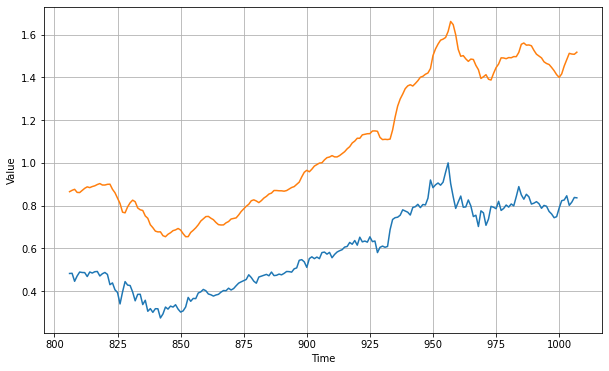

In [56]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [60]:
x_valid.shape

(202,)